In [1]:
import os
import sys
PROJECT_PATH = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
sys.path.append(PROJECT_PATH)

import json
import warnings

from IPython.display import display
import matplotlib.dates as mdates
from matplotlib import patches as mp
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import seaborn as sns
from tabulate import tabulate

from src.data.downloader import Downloader
from src.evaluation.evaluator import Evaluator

warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
%%capture
!pip install matplotlib --upgrade

In [8]:
os.makedirs(os.path.join(PROJECT_PATH, "plots"), exist_ok=True)
to_create_plot = True
to_export_csv = True
to_export_plot = True

# Figure 3.

In [9]:
%%capture
gdrive_link = "https://drive.google.com/uc?export=download&id="
Downloader(gdrive_id="1XMqFFSc65UVE3EYh_tgPHtVRnonshjEO", file_name="all_analysis_for_paper.json") 
Downloader(files=json.load(open(os.path.join(PROJECT_PATH, "data", "all_analysis_for_paper.json"))))

In [10]:
# read metrics summary tables
baseline = pd.read_csv(os.path.join(PROJECT_PATH, "data", "baseline_metrics.csv"), index_col=0)
dense = pd.read_csv(os.path.join(PROJECT_PATH, "data", "mlp_metrics.csv"), index_col=0)
linear = pd.read_csv(os.path.join(PROJECT_PATH, "data", "linear_metrics.csv"), index_col=0)
lstm = pd.read_csv(os.path.join(PROJECT_PATH, "data", "lstm_model_metrics.csv"), index_col=0)

In [11]:
new_df = pd.read_csv(os.path.join(PROJECT_PATH, "data", "Szeged_2014_2020_formated.csv"), 
                     header=0, index_col=0)
y_true = pd.read_csv(os.path.join(PROJECT_PATH, "data", "y_true_2005-01-01_2019-12-24.csv"), 
                     header=0, index_col=0)
LSTM_pred = pd.read_csv(os.path.join(PROJECT_PATH, "data", "lstm_model_raw_prediction_mod.csv"), 
                        header=0, index_col=0)

LSTM_pred_mod = LSTM_pred[LSTM_pred.index.isin(new_df.index)]
LSTM_pred_mod = LSTM_pred_mod['2014-05-14':'2019-12-24'].iloc[:, 0:-1]

y_true_mod = y_true[y_true.index.isin(new_df.index)]
y_true_mod = y_true_mod['2014-05-14':'2019-12-24'].iloc[:, 0:-1]

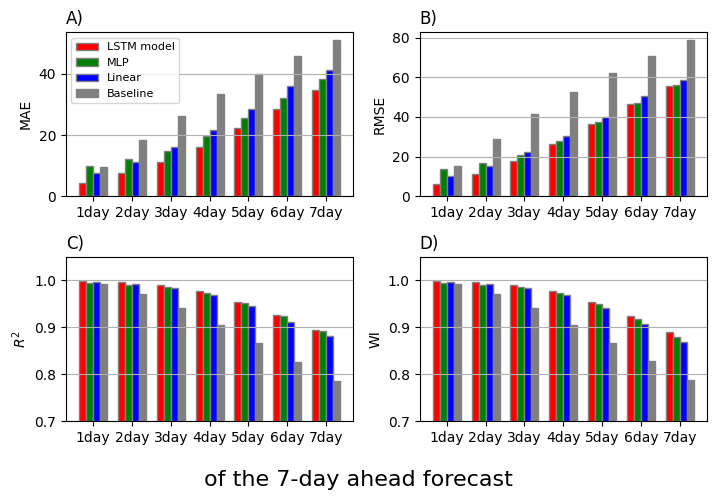

In [12]:
# set font size
plt.rcParams.update({'font.size': 10})

# plot lists for more compact script
models = [lstm, dense, linear, baseline]
colors = ['r', 'g', 'b', 'grey']
labels = ['LSTM model', 'MLP', 'Linear', 'Baseline']
metrics = ['mae', 'rmse', 'r2', 'wi']
alphabet = ['A)', 'B)', 'C)', 'D)']
y_min = [None, None, 0.7, 0.7]

# set up bars
barWidth = 0.18
br1 = np.arange(len(models[0].index))

# create plot
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(7.27, 5)

# loop for metrics
for jdx, metric in enumerate(metrics):
    # loop for models
    for idx, data in enumerate(models):
        axs[int(jdx / 2), jdx % 2].bar(br1 + (idx - 1) * barWidth, data[metric].values,
                                       color=colors[idx],
                                       width=barWidth,
                                       edgecolor='grey',
                                       label=labels[idx])
    axs[int(jdx / 2), jdx % 2].set_title(alphabet[jdx], loc='left')
    axs[int(jdx / 2), jdx % 2].set_ylabel(metric.upper() if metric != 'r2' else r'$R^2$')
    axs[int(jdx / 2), jdx % 2].set_xticks(br1 + barWidth / 2)
    axs[int(jdx / 2), jdx % 2].set_xticklabels(models[0].index)
    axs[int(jdx / 2), jdx % 2].grid(visible=True, which='major', axis='y')
    axs[int(jdx / 2), jdx % 2].set_ylim([y_min[jdx], None])

fig.supxlabel('of the 7-day ahead forecast', size=16)
# set other plot info and parameters
axs[0, 0].legend(labels, loc='upper left', fontsize=8)
plt.tight_layout()
if to_export_plot:
    plt.savefig(os.path.join(PROJECT_PATH, "plots", 'model performance' + ".svg"))
    plt.savefig(os.path.join(PROJECT_PATH, "plots", 'model performance.jpeg'), dpi=350)
    plt.savefig(os.path.join(PROJECT_PATH, "plots", 'model performance' + ".pdf"))
plt.show()

# Table 1.

In [8]:
# print data table
precision = [1, 1, 4, 4]
for jdx, metric in enumerate(metrics):
    data_table = pd.DataFrame(data=np.array([model[metric].values for model in models]).T, index=models[0].index,
                              columns=labels)
    data_table.index.name = metric.upper()
    print('\n')
    print(tabulate(data_table, headers='keys', floatfmt="." + str(precision[jdx]) + "f"))



MAE      LSTM model    MLP    Linear    Baseline
-----  ------------  -----  --------  ----------
1day            4.2    9.9       7.7         9.7
2day            7.6   12.3      11.4        18.4
3day           11.3   14.9      16.0        26.4
4day           16.3   19.6      21.6        33.5
5day           22.4   25.6      28.6        40.0
6day           28.7   32.2      36.1        45.8
7day           34.7   38.4      41.4        51.1


RMSE      LSTM model    MLP    Linear    Baseline
------  ------------  -----  --------  ----------
1day             6.0   13.7      10.3        15.2
2day            11.4   16.6      15.5        29.0
3day            17.6   20.6      22.3        41.4
4day            26.2   28.1      30.5        52.4
5day            36.3   37.5      40.2        62.2
6day            46.3   47.1      50.5        70.9
7day            55.5   55.8      58.4        78.7


R2      LSTM model     MLP    Linear    Baseline
----  ------------  ------  --------  ----------
1day 

# Figure 4.

In [9]:
# shade low mid and high level areas
lowwater = 24
midwater = 239
highwater = 644
floodI = 650
floodII = 750
floodIII = 850

areas = [floodI, floodII, floodIII]
labels_ = ['floodI', 'floodII', 'floodIII']

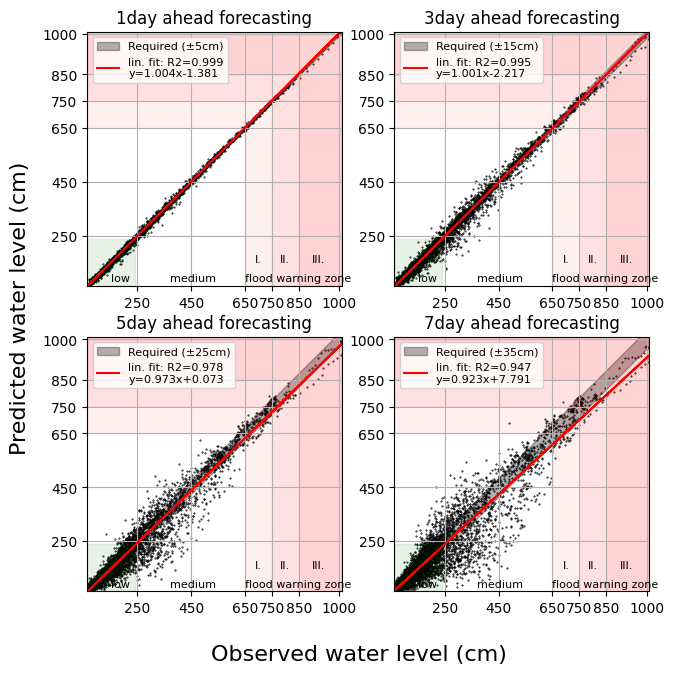

In [10]:
# plot lists for more compact script
colors = ['black', 'red', 'black', 'red']
labels = ['Required', 'fit']
days_to_plot = ['1day', '3day', '5day', '7day']
forecast_err = [5, 15, 25, 35]

# create plot
fig, axs = plt.subplots(2, 2, sharey='all', sharex='all')
fig.set_size_inches(7.27, 7.27)

# loop for days to plot
for jdx, day in enumerate(days_to_plot):
    # get data to plot
    obse = y_true[day].values
    pred = LSTM_pred[day].values

    # Scatterplot
    axs[int(jdx / 2), jdx % 2].scatter(obse, pred, c=colors[0], s=0.2, label='_nolegend_')

    # expectation: plot forecast_target_errors around observed
    axs[int(jdx / 2), jdx % 2].fill_between(
        np.sort(obse), np.sort(obse) - forecast_err[jdx],
        np.sort(obse) + forecast_err[jdx], 
        color=colors[2], alpha=0.3, label=labels[0])

    # Fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(obse, pred)
    axs[int(jdx / 2), jdx % 2].plot(obse, slope * obse + intercept, color=colors[1])

    # midwater
    x = [min(obse), midwater]
    y_min = [min(obse), min(obse)]
    y_max = [midwater, midwater]
    axs[int(jdx / 2), jdx % 2].fill_between(x, y_min, y_max, color='green', alpha=0.1, label='low')

    for area, label in zip(areas, labels_):
        x = [min(obse), area, area + 0.001, max(obse)]
        y_min = [area, area, min(obse), min(obse)]
        y_max = [max(obse), max(obse), max(obse), max(obse)]
        axs[int(jdx / 2), jdx % 2].fill_between(x, y_min, y_max, color='red', alpha=0.06, label=label)

    # water level text
    axs[int(jdx / 2), jdx % 2].text(150, 80, 'low', fontsize=8)
    axs[int(jdx / 2), jdx % 2].text(370, 80, 'medium', fontsize=8)
    axs[int(jdx / 2), jdx % 2].text(650, 80, 'flood warning zone', fontsize=8)
    axs[int(jdx / 2), jdx % 2].text(700, 150, 'I.', fontsize=8, horizontalalignment='center')
    axs[int(jdx / 2), jdx % 2].text(800, 150, 'II.', fontsize=8, horizontalalignment='center')
    axs[int(jdx / 2), jdx % 2].text(925, 150, 'III.', fontsize=8, horizontalalignment='center')

    # Legends
    text_str = '\n'.join((r'lin. fit: R2=%.3f' % (r_value,), r'y=%.3fx%+.3f' % (slope, intercept)))
    labels[1] = text_str
    tmp = labels[0]
    labels[0] = "Required" + " (\u00B1" + str(forecast_err[jdx]) + "cm)"
    axs[int(jdx / 2), jdx % 2].legend(labels, loc='best', prop={'size': 8})
    labels[0] = tmp
    # Square
    axs[int(jdx / 2), jdx % 2].set_aspect('equal', adjustable='box')
    # set axis title
    axs[int(jdx / 2), jdx % 2].set_title(day + ' ahead forecasting', size=12)
    # add grid
    axs[int(jdx / 2), jdx % 2].grid()
    # ticks
    ticks = np.array([250, 450, 650, 750, 850, 1000])
    axs[int(jdx / 2), jdx % 2].set_xticks(ticks)
    axs[int(jdx / 2), jdx % 2].set_xticklabels(ticks, fontsize=10)
    axs[int(jdx / 2), jdx % 2].set_yticks(ticks)
    axs[int(jdx / 2), jdx % 2].set_yticklabels(ticks, fontsize=10)
    # limits
    axs[int(jdx / 2), jdx % 2].set_xlim(left=min(obse), right=max(obse))
    axs[int(jdx / 2), jdx % 2].set_ylim(bottom=min(obse), top=max(obse))
    # show all
    axs[int(jdx / 2), jdx % 2].xaxis.set_tick_params(labelbottom=True)
    axs[int(jdx / 2), jdx % 2].yaxis.set_tick_params(labelbottom=True)

# set other plot info and parameters
title = "Predicted vs observed data"
# fig.suptitle(title)
# plt.rcParams['figure.constrained_layout.use'] = True
# plt.tight_layout()
fig.supxlabel('Observed water level (cm)', size=16)
fig.supylabel('Predicted water level (cm)', size=16)
if to_export_plot:
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".svg"))
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".pdf"))
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".jpeg"), dpi=350)
plt.show()

# Figure 5.

Number of data points: 5471


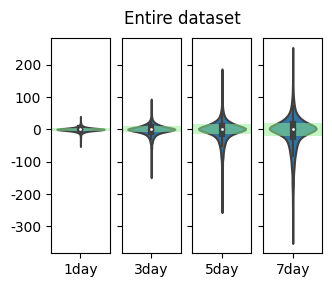

In [11]:
n_data = LSTM_pred.shape[0]
print("Number of data points:", n_data)
result = []

# PLOT RESULTS
ax = None
if to_create_plot:
    fig, ax = plt.subplots(1, 4, figsize=(3.5, 2.8), sharey='all')
for idy, dy in enumerate(days_to_plot):
    diffs = LSTM_pred[dy].values - y_true[dy].values
    n_in = np.sum(np.abs(diffs) < forecast_err[idy])
    n_low = np.sum(diffs < -forecast_err[idy])
    n_upper = np.sum(diffs > forecast_err[idy])
    med = np.median(np.abs(diffs))
    mini = np.min(np.abs(diffs))
    maxi = np.max(np.abs(diffs))
    result.append([n_in / n_data * 100, 
                   n_low / n_data * 100, 
                   n_upper / n_data * 100, 
                   med, mini, maxi])
    if to_create_plot:
        vplt = sns.violinplot(
            pd.DataFrame(
                data=diffs, 
                index=LSTM_pred.index,
                columns=[dy]
        ), orient="v", ax=ax[idy])
        vplt.set_xticklabels([dy], fontsize=10)
        vplt.set_yticks(np.arange(-300, 300, 100))
        vplt.set_yticklabels(np.arange(-300, 300, 100), fontsize=10)
        bx = mp.Rectangle(xy=(-1,-(idy + 1) * 5), 
                          width=2, height=(idy + 1) * 5 * 2)
        pc = mc.PatchCollection([bx], alpha=0.5, facecolor="lightgreen")
        ax[idy].add_collection(pc)
fig.suptitle("Entire dataset", fontsize=12)

if to_export_plot and to_create_plot:
    plt.savefig(os.path.join(PROJECT_PATH, "plots","summary_violin.pdf"))
    plt.savefig(os.path.join(PROJECT_PATH, "plots","summary_violin.jpeg"), dpi=350)

# Table 2.

In [12]:
# PRINT STATISTICS
result_ptg = np.array(result)

pdf = pd.DataFrame(
    data=result_ptg,
    columns=["Inside (%)", "Lower (%)", "Higher (%)", 
             "Med. abs. diff.", 
             "Min. abs. diff.", 
             "Max. abs. diff."],
    index=days_to_plot
)
display(pdf)
if to_export_csv:
    pdf.to_csv(os.path.join(PROJECT_PATH, "data/generated/summary.csv"))

,Inside (%),Lower (%),Higher (%),Med. abs. diff.,Min. abs. diff.,Max. abs. diff.
1day,70.901115,16.048254,13.050631,2.94586,0.000780,51.08026
3day,76.128678,14.165600,9.705721,6.98289,0.000370,143.53642
5day,71.833303,17.876074,10.290623,12.41123,0.005646,245.20728
7day,68.470115,20.160848,11.369037,18.53915,0.008330,334.03258


# Table 3-5. + Figure 5.

-inf <= true water level < 240 : number of data points = 3816


,Inside (%),Lower (%),Higher (%),Med. abs. diff.,Min. abs. diff.,Max. abs. diff.
1day,76.729560,15.382600,7.887841,2.520935,0.000780,43.46460
3day,83.202306,12.631027,4.166667,5.576110,0.000370,143.53642
5day,80.241090,15.749476,4.009434,8.998875,0.005646,245.20728
7day,77.830189,17.426625,4.743187,12.729990,0.008330,304.62912




240 <= true water level < 650 : number of data points = 1427


,Inside (%),Lower (%),Higher (%),Med. abs. diff.,Min. abs. diff.,Max. abs. diff.
1day,55.711282,17.799580,26.489138,4.45980,0.00446,51.08026
3day,57.603364,18.290119,24.106517,12.57552,0.01500,108.79367
5day,50.385424,23.125438,26.489138,24.78226,0.08600,215.43573
7day,44.779257,26.629292,28.591451,40.66824,0.01819,334.03258




650 <= true water level < inf : number of data points = 228


,Inside (%),Lower (%),Higher (%),Med. abs. diff.,Min. abs. diff.,Max. abs. diff.
1day,68.421053,16.228070,15.350877,3.288085,0.0486,16.08860
3day,73.684211,14.035088,12.280702,9.640870,0.1087,43.08440
5day,65.350877,20.614035,14.035088,18.762850,0.2529,69.87010
7day,60.087719,25.438596,14.473684,26.171970,0.3152,92.21204


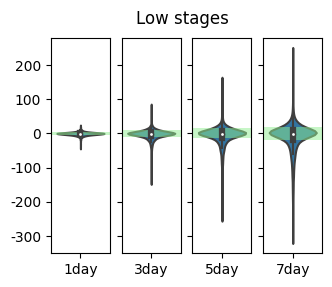

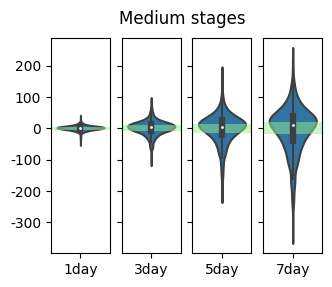

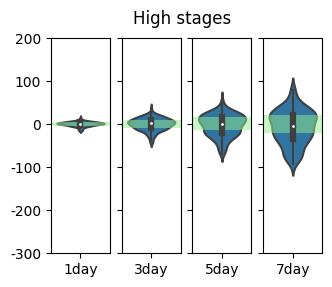

In [13]:
thr = [-np.inf, 240, 650, np.inf]
suptitles = ["Low stages", "Medium stages", "High stages"]

for idx in range(len(thr) - 1):
    y_true_filter = (thr[idx] <= y_true["1day"].values) & (y_true["1day"].values < thr[idx + 1])
    y_true_filt = y_true.iloc[y_true_filter]
    lstm_pred_filt = LSTM_pred.iloc[y_true_filter]
    n_data = lstm_pred_filt.shape[0]
    result = []
    
    if to_create_plot:
        fig, ax = plt.subplots(1, 4, figsize=(3.5, 2.8), sharey='all')
    for idy, dy in enumerate(days_to_plot):
        diffs = lstm_pred_filt[dy].values - y_true_filt[dy].values
        n_in = np.sum(np.abs(diffs) < forecast_err[idy])
        n_low = np.sum(diffs < -forecast_err[idy])
        n_upper = np.sum(diffs > forecast_err[idy])
        med = np.median(np.abs(diffs))
        mini = np.min(np.abs(diffs))
        maxi = np.max(np.abs(diffs))
        result.append([n_in / n_data * 100, 
                       n_low / n_data * 100, 
                       n_upper / n_data * 100, 
                       med, mini, maxi])
        
        if to_create_plot:
            vplt = sns.violinplot(
                pd.DataFrame(
                    data=diffs, 
                    index=lstm_pred_filt.index,
                    columns=[dy]
            ), orient="v", ax=ax[idy])
            vplt.set_xticklabels([dy], fontsize=10)
            vplt.set_yticks(np.arange(-300, 300, 100))
            vplt.set_yticklabels(np.arange(-300, 300, 100), fontsize=10)
            bx = mp.Rectangle(xy=(-1,-(idy + 1) * 5), 
                              width=2, height=(idy + 1) * 5 * 2)
            pc = mc.PatchCollection([bx], alpha=0.5, facecolor="lightgreen")
            ax[idy].add_collection(pc)
    fig.suptitle(suptitles[idx], fontsize=12)
    
    if to_export_plot and to_create_plot:
        plt.savefig(os.path.join(PROJECT_PATH, "plots","summary_" + 
                                 str(idx) + "_violin.pdf"))
        plt.savefig(os.path.join(PROJECT_PATH, "plots","summary_" + 
                                 str(idx) + "_violin.jpeg"), dpi=350)
    
    # PRINT STATISTICS
    result_ptg = np.array(result)
    
    print(thr[idx], "<=", "true water level", "<", thr[idx + 1], ": number of data points =", n_data)
    pdf = pd.DataFrame(
        data=result_ptg,
        columns=["Inside (%)", "Lower (%)", "Higher (%)", 
                 "Med. abs. diff.", 
                 "Min. abs. diff.", 
                 "Max. abs. diff."],
        index=days_to_plot)
    if to_export_csv:
        pdf.to_csv(os.path.join(PROJECT_PATH, "data/generated/summary_" + str(idx) + ".csv"))
    display(pdf)
    print("\n")

# Figure 6-7.
(A 2 by 2 figure of time-series plots. 1 plot per horizon. Required +- X cm precision is shown as dashed lines/shaded area.)
The LSTM model's time-series forecasting of the 2006 flood
over different forecasting horizons: (a) 1-day; (b) 3-day; (c) 5-day; (d) 7-day.

In [14]:
def get_confidence(obs, predi, w_size=15, sigm=1):
    """Calculate confidence according to Vizi-formula"""
    # calculate difference
    diff = abs(obs - predi)
    # convert date index to int
    diff.index = np.arange(0, len(diff.index))
    # create empty conf container
    confi = []
    for index in diff.index:
        row = []
        for col in diff.columns:
            # mean of the difference in the past window_size days
            # simga as a magic parameter
            cf = np.mean(diff[col][index - w_size:index].values) * sigm
            row.append(cf)
        confi.append(row)
    confi = pd.DataFrame(index=predi.index, data=confi, columns=predi.columns)
    return confi

In [15]:
# read 1-7days data
observed = pd.read_csv(os.path.join(PROJECT_PATH, "data", "y_true_2005-01-01_2019-12-24.csv"), index_col=0)
predicted = pd.read_csv(os.path.join(PROJECT_PATH, "data", "lstm_model_raw_prediction_mod.csv"), index_col=0)

In [16]:
# time interval
select = 2006  # 2013
if select == 2006:
    start_date = '2006-03-20'
    end_date = '2006-05-20'
elif select == 2013:
    start_date = '2013-04-04'  # 2013-04-04  # 2013-03-10
    end_date = '2013-05-09'  # 2013-05-12
else:
    raise Exception("Undefined behavior!")

# get model confidence window_size and sigma can be changed
window_size = 10
sigma = 1
confidence = get_confidence(obs=observed, predi=predicted,
                            w_size=window_size, sigm=sigma)

# shift observed data
observed.index = pd.DatetimeIndex(observed.index) + pd.DateOffset(1)
x = observed[start_date:end_date].index
y_obs = observed[observed.columns[0]][start_date:end_date].values
y_pred_eval = []

/home/zsvizi/workspace/water-prediction-lstm-tisza/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zsvizi/workspace/water-prediction-lstm-tisza/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


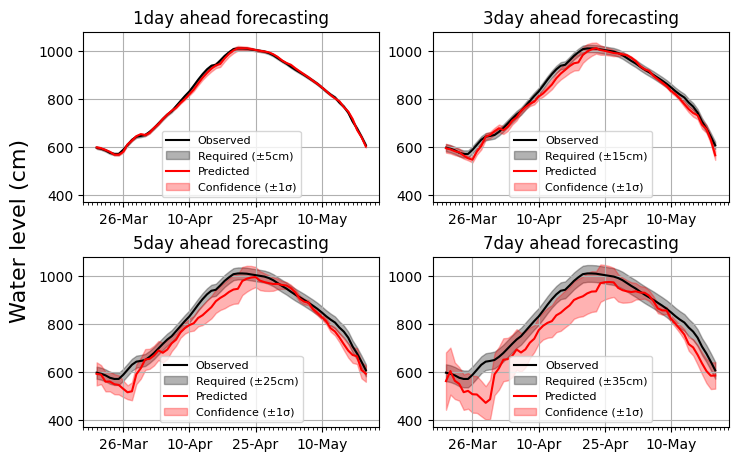

In [17]:
# set font size
plt.rcParams.update({'font.size': 10})

# plot lists for more compact script
colors = ['black', 'red', 'black', 'red']
forecast_err = [5, 15, 25, 35]
labels = ['Observed', 'Required', 'Predicted', 'Confidence']
days_to_plot = ['1day', '3day', '5day', '7day']
title_ext = " flood prediction"
y_title = 'Water level (cm)'
sub_title_ext = ' ahead forecasting'
labels[3] = labels[3] + " (\u00B1" + str(sigma) + "\u03C3)"

# create plot
fig, axs = plt.subplots(2, 2, sharey='all')
fig.set_size_inches(7.27, 4.5)

# loop for metrics
for jdx, day in enumerate(days_to_plot):
    # plot observed
    axs[int(jdx / 2), jdx % 2].plot(x, y_obs, color=colors[0], label=labels[0])
    # plot forecast_target_errors around observed
    axs[int(jdx / 2), jdx % 2].fill_between(
        x, y_obs - forecast_err[jdx], y_obs + forecast_err[jdx], 
        color=colors[2], alpha=0.3, label=labels[2])
    
    # shift prediction data by day
    predicted_shift = predicted.copy()
    predicted_shift.index = pd.DatetimeIndex(predicted_shift.index) + pd.DateOffset(int(day[0]))
    y_pred = predicted_shift[day][start_date:end_date].values
    y_pred_eval.append(y_pred)
    # create plot
    axs[int(jdx / 2), jdx % 2].plot(
        x, y_pred, 
        color=colors[1], label=labels[1])
    # confidence around predicted
    confidence_shift = confidence.copy()
    confidence_shift.index = pd.DatetimeIndex(confidence_shift.index) + pd.DateOffset(int(day[0]) - 1)
    conf = confidence_shift[day][start_date:end_date].values
    # create plot
    axs[int(jdx / 2), jdx % 2].fill_between(
        x, y_pred - conf, y_pred + conf, 
        color=colors[3], alpha=0.3, label=labels[3])

    # set axis title
    axs[int(jdx / 2), jdx % 2].set_title(day + sub_title_ext, size=12)
    # format x_ticks
    axs[int(jdx / 2), jdx % 2].xaxis.set_major_locator(mdates.DayLocator(interval=15))
    axs[int(jdx / 2), jdx % 2].xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
    axs[int(jdx / 2), jdx % 2].xaxis.set_minor_locator(mdates.DayLocator())
    # show ytick
    axs[int(jdx / 2), jdx % 2].yaxis.set_tick_params(labelbottom=True)
    # set grid
    axs[int(jdx / 2), jdx % 2].grid()
    # set legends
    tmp = labels[1]
    labels[1] = labels[1] + " (\u00B1" + str(forecast_err[jdx]) + "cm)"
    axs[int(jdx / 2), jdx % 2].legend(labels, loc='best', prop={'size': 8})
    labels[1] = tmp

# set other plot info and parameters
title = str(select) + title_ext
# fig.suptitle(title)
plt.rcParams['figure.constrained_layout.use'] = True
# plt.tight_layout()
fig.supylabel(y_title, size=16)
if to_export_plot:
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".svg"))
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".pdf"))
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".jpeg"), dpi=350)
plt.show()

# Table 6.

In [18]:
thrshld = 700 if select == 2013 else 980 # 980
filter_temp = y_obs < thrshld
filter_peak = y_obs > thrshld
filter_decr = np.cumsum(np.append([0], np.diff(filter_temp)) != 0) == 2
filter_incr = np.array(filter_temp.astype(int) - filter_decr.astype(int), dtype=bool)

In [19]:
filt_list = [filter_incr, filter_peak, filter_decr]
result_mae = []
for jdx in range(len(y_pred_eval)):
    row_mae = []
    for p_idx, ph in enumerate(['incr', 'peak', 'decr']):
        flt = filt_list[p_idx]
        obsr = y_obs[flt]
        pred = y_pred_eval[jdx][flt]
        mae = np.mean(np.abs(pred - obsr))
        row_mae.append(mae)
    result_mae.append(row_mae)
df_mae = pd.DataFrame(
    data=np.array(result_mae),
    columns=["Increasing", "Peaking", "Decreasing"],
    index=days_to_plot
)

if to_export_csv:
    df_mae.to_csv(os.path.join(PROJECT_PATH, "data/generated", str(select) + "_mae.csv"))

print("Mean Absolute Error")
display(df_mae)
print("Date for increasing until", thrshld, "=", x[filter_incr][-1])
print("Date for peaking until", thrshld, "=", x[filter_peak][-1])

Mean Absolute Error


,Increasing,Peaking,Decreasing
1day,6.222017,2.151807,3.444082
3day,17.560448,9.674142,13.247455
5day,39.246284,31.079587,21.227925
7day,70.616848,55.294452,34.276489


Date for increasing until 980 = 2006-04-18 00:00:00
Date for peaking until 980 = 2006-04-29 00:00:00


# Figure 8. (data generation)

In [20]:
model_name = 'LSTM'

print("Evaluated model: " + model_name)
evaluator = Evaluator(validation_df=y_true_mod, prediction_df=LSTM_pred_mod)

# All validation data
stats = evaluator.calculate_all_stats()
print("\nAll validation data")
print(tabulate(stats, headers='keys', floatfmt=".4f"))

stats.to_csv(os.path.join(PROJECT_PATH, "data", "generated", model_name + "_test" + ".csv"))

Evaluated model: LSTM

All validation data
         rmse      mae      r2     nse      wi     mape    rmae        mse    rrmse    rmsre    nnse    anse    nanse      fc       lm     nwi    corr
----  -------  -------  ------  ------  ------  -------  ------  ---------  -------  -------  ------  ------  -------  ------  -------  ------  ------
1day   5.5105   3.8028  0.9977  0.9977  0.9977   2.4150  1.9501    30.3656   3.0284   0.4085  0.9977  0.9548   0.9568  0.0261  -0.5054  0.9977  0.9989
2day  10.4988   6.8911  0.9915  0.9915  0.9917   4.1028  2.6251   110.2250   5.7698   0.7783  0.9916  0.9181   0.9243  0.0370  -1.7279  0.9918  0.9959
3day  16.2349  10.0426  0.9797  0.9797  0.9803   5.6907  3.1690   263.5721   8.9242   1.2037  0.9801  0.8807   0.8934  0.0472  -2.9749  0.9807  0.9901
4day  23.8267  14.2092  0.9563  0.9563  0.9570   7.5774  3.7695   567.7097  13.1006   1.7668  0.9581  0.8312   0.8556  0.0586  -4.6239  0.9588  0.9785
5day  32.5944  19.3489  0.9181  0.9181  0.9177   9.

In [21]:
model_name = 'reference'

print("Evaluated model: " + model_name)
evaluator = Evaluator(validation_df=y_true_mod, prediction_df=new_df['2014-05-14':'2019-12-24'])

# All validation data
stats = evaluator.calculate_all_stats()
print("\nAll validation data")
print(tabulate(stats, headers='keys', floatfmt=".4f"))

stats.to_csv(os.path.join(PROJECT_PATH, "data", "generated", model_name + "_test" + ".csv"))

Evaluated model: reference

All validation data
         rmse      mae      r2     nse      wi     mape    rmae        mse    rrmse    rmsre    nnse    anse    nanse      fc       lm     nwi    corr
----  -------  -------  ------  ------  ------  -------  ------  ---------  -------  -------  ------  ------  -------  ------  -------  ------  ------
1day   8.9369   5.4614  0.9938  0.9938  0.9940   3.1289  2.3370    79.8677   4.9115   0.6625  0.9939  0.9351   0.9390  0.0350  -1.1620  0.9940  0.9970
2day  14.7655   9.4589  0.9832  0.9832  0.9837   5.2773  3.0755   218.0207   8.1147   1.0946  0.9835  0.8876   0.8989  0.0450  -2.7444  0.9840  0.9918
3day  20.3932  13.2671  0.9680  0.9680  0.9692   7.2798  3.6424   415.8839  11.2100   1.5120  0.9689  0.8424   0.8639  0.0528  -4.2512  0.9701  0.9845
4day  25.8192  16.6276  0.9486  0.9486  0.9509   9.0107  4.0777   666.6306  14.1962   1.9145  0.9511  0.8025   0.8350  0.0593  -5.5811  0.9532  0.9751
5day  30.5701  19.8057  0.9280  0.9280  0.9307

# Figure 8. (plot generation)

In [22]:
lstm = pd.read_csv(os.path.join(PROJECT_PATH, "data", "generated", "LSTM_test.csv"), index_col=0)
reference = pd.read_csv(os.path.join(PROJECT_PATH, "data", "generated", "reference_test.csv"), index_col=0)

/tmp/ipykernel_10681/3310469898.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


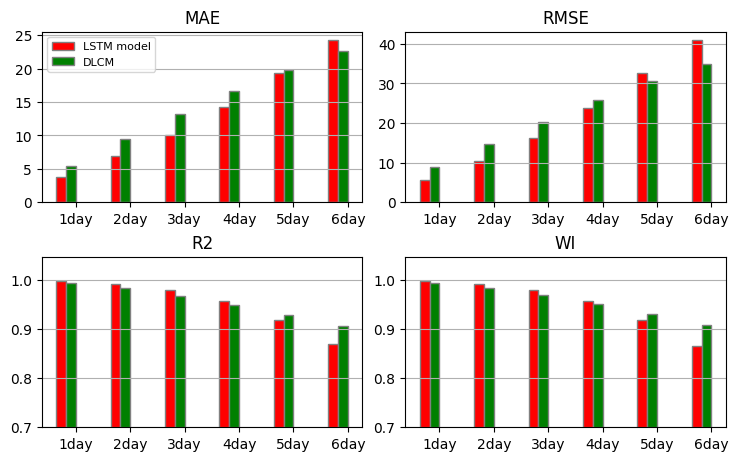

In [23]:
# set font size
plt.rcParams.update({'font.size': 10})

# plot lists for more compact script
models = [lstm, reference]
labels = ['LSTM model', 'DLCM']
colors = ['r', 'g', 'b', 'grey']
metrics = ['mae', 'rmse', 'r2', 'wi']
y_min = [None, None, 0.7, 0.7]

# set up bars
barWidth = 0.18
indexes = ['1day', '2day', '3day', '4day', '5day', '6day']
br1 = np.arange(len(models[0].index))

# create plot
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(7.27, 4.5)

# loop for metrics
for jdx, metric in enumerate(metrics):
    # loop for models
    for idx, data in enumerate(models):
        axs[int(jdx / 2), jdx % 2].bar(br1 + (idx - 1) * barWidth, data[metric].values, color=colors[idx],
                                       width=barWidth, edgecolor='grey', label=labels[idx])
    axs[int(jdx / 2), jdx % 2].set_title(metric.upper(), fontsize=12)
    axs[int(jdx / 2), jdx % 2].set_xticks(br1 + barWidth / 2)
    axs[int(jdx / 2), jdx % 2].set_xticklabels(indexes, fontsize=10)
    axs[int(jdx / 2), jdx % 2].grid(visible=True, which='major', axis='y')
    axs[int(jdx / 2), jdx % 2].set_ylim([y_min[jdx], None])

# set other plot info and parameters
axs[0, 0].legend(labels, loc='upper left', prop={'size': 8})
plt.tight_layout()
if to_export_plot:
    plt.savefig(os.path.join(PROJECT_PATH, "plots", 'model performance 2' + ".pdf"))
    plt.savefig(os.path.join(PROJECT_PATH, "plots", 'model performance 2' + ".jpeg"), dpi=350)
plt.show()

In [24]:
# print data table
precision = [1, 1, 4, 4]
for jdx, metric in enumerate(metrics):
    data_table = pd.DataFrame(data=np.array([model[metric].values for model in models]).T, index=models[0].index,
                              columns=labels)
    data_table.index.name = metric.upper()
    print('\n')
    print(tabulate(data_table, headers='keys', floatfmt="." + str(precision[jdx]) + "f"))



MAE      LSTM model    DLCM
-----  ------------  ------
1day            3.8     5.5
2day            6.9     9.5
3day           10.0    13.3
4day           14.2    16.6
5day           19.3    19.8
6day           24.3    22.6


RMSE      LSTM model    DLCM
------  ------------  ------
1day             5.5     8.9
2day            10.5    14.8
3day            16.2    20.4
4day            23.8    25.8
5day            32.6    30.6
6day            41.0    34.8


R2      LSTM model    DLCM
----  ------------  ------
1day        0.9977  0.9938
2day        0.9915  0.9832
3day        0.9797  0.9680
4day        0.9563  0.9486
5day        0.9181  0.9280
6day        0.8702  0.9067


WI      LSTM model    DLCM
----  ------------  ------
1day        0.9977  0.9940
2day        0.9917  0.9837
3day        0.9803  0.9692
4day        0.9570  0.9509
5day        0.9177  0.9307
6day        0.8657  0.9089


# Figure 9.

In [25]:
observed = pd.read_csv(os.path.join(PROJECT_PATH, "data", "y_true_mod.csv"), index_col=0)
predicted_LSTM = pd.read_csv(os.path.join(PROJECT_PATH, "data", "LSTM_pred_mod.csv"), index_col=0)
predicted_ATIVIZIG = pd.read_csv(os.path.join(PROJECT_PATH, "data", "Szeged_2014_2020_formated.csv"), index_col=0)

predicted = {'LSTM': predicted_LSTM, 'DLCM': predicted_ATIVIZIG}

In [26]:
# shade low mid and high level areas
lowwater = 24
midwater = 239
highwater = 644
floodI = 650
floodII = 750
floodIII = 850

areas = [floodI, floodII, floodIII]
# labels = ['floodI', 'floodII', 'floodIII']

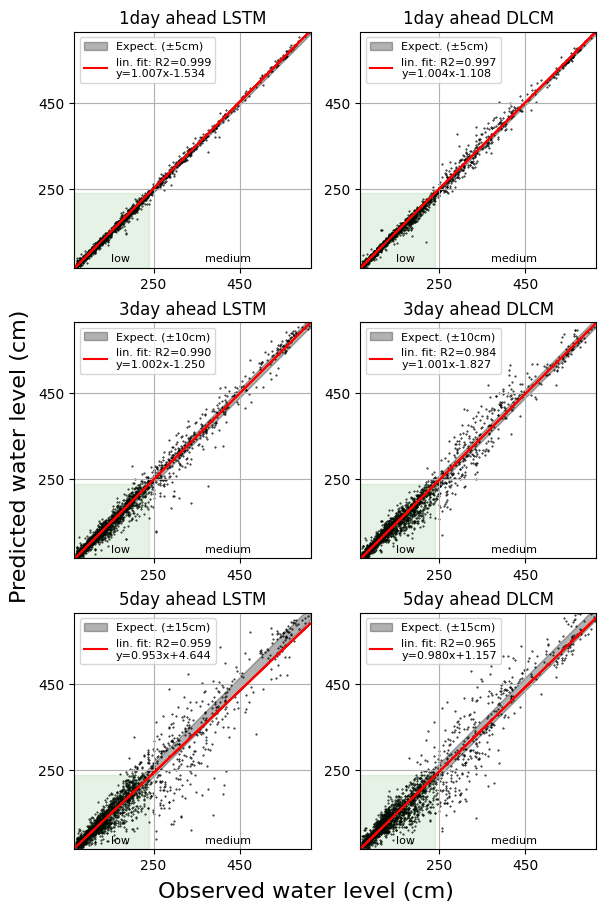

In [27]:
# plot lists for more compact script
colors = ['black', 'red', 'black', 'red']
labels = ['Expect.', 'fit']
days_to_plot = ['1day', '3day', '5day']
forecast_err = [5, 10, 15, 20, 25, 30, 35]

# create plot
fig, axs = plt.subplots(len(days_to_plot), len(predicted.keys()), sharey='all', sharex='all')
fig.set_size_inches(6, 9)

# iterate models
for idx, key in enumerate(predicted.keys()):
    # loop for days to plot
    for jdx, day in enumerate(days_to_plot):
        # get data to plot
        obse = observed[day].values
        pred = predicted[key][day].values

        # Scatterplot
        axs[jdx, idx].scatter(obse, pred, c=colors[0], s=0.2, label='_nolegend_')

        # expectation: plot forecast_target_errors around observed
        axs[jdx, idx].fill_between(
            np.sort(obse), np.sort(obse) - forecast_err[jdx], np.sort(obse) + forecast_err[jdx],
            color=colors[2], alpha=0.3, label=labels[0])

        # Fit line
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(obse, pred)
        axs[jdx, idx].plot(obse, slope * obse + intercept, color=colors[1])

        # midwater
        x = [min(obse), midwater]
        y_min = [min(obse), min(obse)]
        y_max = [midwater, midwater]
        axs[jdx, idx].fill_between(x, y_min, y_max, color='green', alpha=0.1, label='low')

        for area, label in zip(areas, labels):
            x = [min(obse), area, area + 0.001, max(obse)]
            y_min = [area, area, min(obse), min(obse)]
            y_max = [max(obse), max(obse), max(obse), max(obse)]
            axs[jdx, idx].fill_between(x, y_min, y_max, color='red', alpha=0.06, label=label)

        # water level text
        axs[jdx, idx].text(150, 80, 'low', fontsize=8)
        axs[jdx, idx].text(370, 80, 'medium', fontsize=8)

        # Legends
        text_str = '\n'.join((r'lin. fit: R2=%.3f' % (r_value,), r'y=%.3fx%+.3f' % (slope, intercept)))
        labels[1] = text_str
        tmp = labels[0]
        labels[0] = labels[0] + " (\u00B1" + str(forecast_err[jdx]) + "cm)"
        axs[jdx, idx].legend(labels, loc='best', prop={'size': 8})
        labels[0] = tmp

        # Square
        axs[jdx, idx].set_aspect('equal', adjustable='box')
        # set axis title
        axs[jdx, idx].set_title(day + ' ahead ' + key, size=12)
        # add grid
        axs[jdx, idx].grid()
        # ticks
        ticks = np.array([250, 450, 650, 750, 850, 1000])
        axs[jdx, idx].set_xticks(ticks)
        axs[jdx, idx].set_xticklabels(ticks, fontsize=10)
        axs[jdx, idx].set_yticks(ticks)
        axs[jdx, idx].set_yticklabels(ticks, fontsize=10)
        # limits
        axs[jdx, idx].set_xlim(left=min(obse), right=max(obse))
        axs[jdx, idx].set_ylim(bottom=min(obse), top=max(obse))
        # show all
        axs[jdx, idx].xaxis.set_tick_params(labelbottom=True)
        axs[jdx, idx].yaxis.set_tick_params(labelbottom=True)

# set other plot info and parameters
title = "LSTM and DLCM predicted vs observed"
# fig.suptitle(title, fontsize=16)
# plt.rcParams['figure.constrained_layout.use'] = True
# plt.tight_layout()
fig.supxlabel('Observed water level (cm)', size=16)
fig.supylabel('Predicted water level (cm)', size=16)
if to_export_plot:
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".pdf"))
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".jpeg"), dpi=350)
plt.show()

# Table 7.

In [29]:
thr = [-np.inf, 240, np.inf]

for mod in predicted.keys():
    for idx in range(len(thr) - 1):
        y_true_filter = (thr[idx] <= observed["1day"].values) & (observed["1day"].values < thr[idx + 1])
        y_true_filt = observed.iloc[y_true_filter]
        lstm_pred_filt = predicted[mod].iloc[y_true_filter]
        n_data = lstm_pred_filt.shape[0]
        result = []
            
        for idy, dy in enumerate(days_to_plot):
            diffs = lstm_pred_filt[dy].values - y_true_filt[dy].values
            n_in = np.sum(np.abs(diffs) < forecast_err[idy])
            n_low = np.sum(diffs <= -forecast_err[idy])
            n_upper = np.sum(diffs >= forecast_err[idy])
            med = np.median(np.abs(diffs))
            mini = np.min(np.abs(diffs))
            maxi = np.max(np.abs(diffs))
            result.append([n_in / n_data * 100, 
                           n_low / n_data * 100, 
                           n_upper / n_data * 100, 
                           med, mini, maxi])

        # PRINT STATISTICS
        result_ptg = np.array(result)

        print(thr[idx], "<=", "true water level", "<", thr[idx + 1], 
              ": number of data points =", n_data, "for", mod)
        pdf = pd.DataFrame(
            data=result_ptg,
            columns=["Inside (%)", "Lower (%)", "Higher (%)", 
                     "Med. abs. diff.", 
                     "Min. abs. diff.", 
                     "Max. abs. diff."],
            index=days_to_plot)
        if to_export_csv:
            pdf.to_csv(os.path.join(PROJECT_PATH, "data/generated/summary_" + mod + "_" + str(idx) + ".csv"))
        display(pdf)
        print("\n")

-inf <= true water level < 240 : number of data points = 1624 for LSTM


,Inside (%),Lower (%),Higher (%),Med. abs. diff.,Min. abs. diff.,Max. abs. diff.
1day,78.879310,13.115764,8.004926,2.442945,0.002320,43.46460
3day,73.830049,15.886700,10.283251,5.149165,0.000370,143.53642
5day,69.519704,19.334975,11.145320,8.292970,0.005646,245.20728




240 <= true water level < inf : number of data points = 409 for LSTM


,Inside (%),Lower (%),Higher (%),Med. abs. diff.,Min. abs. diff.,Max. abs. diff.
1day,59.168704,13.691932,27.139364,4.24063,0.00768,41.67540
3day,44.498778,16.870416,38.630807,11.39517,0.01500,83.85250
5day,32.273839,24.205379,43.520782,23.34311,0.12378,154.13312




-inf <= true water level < 240 : number of data points = 1624 for DLCM


,Inside (%),Lower (%),Higher (%),Med. abs. diff.,Min. abs. diff.,Max. abs. diff.
1day,70.443350,18.411330,11.145320,3.0,0.0,95.0
3day,63.608374,21.366995,15.024631,7.0,0.0,134.0
5day,63.977833,20.689655,15.332512,10.0,0.0,197.0




240 <= true water level < inf : number of data points = 409 for DLCM


,Inside (%),Lower (%),Higher (%),Med. abs. diff.,Min. abs. diff.,Max. abs. diff.
1day,39.119804,30.562347,30.317848,7.0,0.0,88.0
3day,34.229829,30.317848,35.452323,17.0,0.0,106.0
5day,31.295844,31.295844,37.408313,26.0,0.0,158.0


# Figure 10.

In [30]:
# read 1-7days data
observed = pd.read_csv(os.path.join(PROJECT_PATH, "data", "y_true_mod.csv"), index_col=0)
predicted = pd.read_csv(os.path.join(PROJECT_PATH, "data", "LSTM_pred_mod.csv"), index_col=0)
dlcm = pd.read_csv(os.path.join(PROJECT_PATH, "data", "Szeged_2014_2020_formated.csv"), index_col=0)

In [31]:
# get model confidence window_size and sigma can be changed
window_size = 10
sigma = 1
confidence = get_confidence(obs=observed, predi=predicted,
                            w_size=window_size, sigm=sigma)

confidence_dlcm = get_confidence(obs=observed, predi=dlcm,
                                w_size=window_size, sigm=sigma)
# shift observed data
observed.index = pd.DatetimeIndex(observed.index) + pd.DateOffset(1)

# time interval
select = 2019
start_date = '2019-05-01'
end_date = '2019-07-01'

x = observed[start_date:end_date].index
y_obs = observed[observed.columns[0]][start_date:end_date].values

/home/zsvizi/workspace/water-prediction-lstm-tisza/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zsvizi/workspace/water-prediction-lstm-tisza/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zsvizi/workspace/water-prediction-lstm-tisza/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zsvizi/workspace/water-prediction-lstm-tisza/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


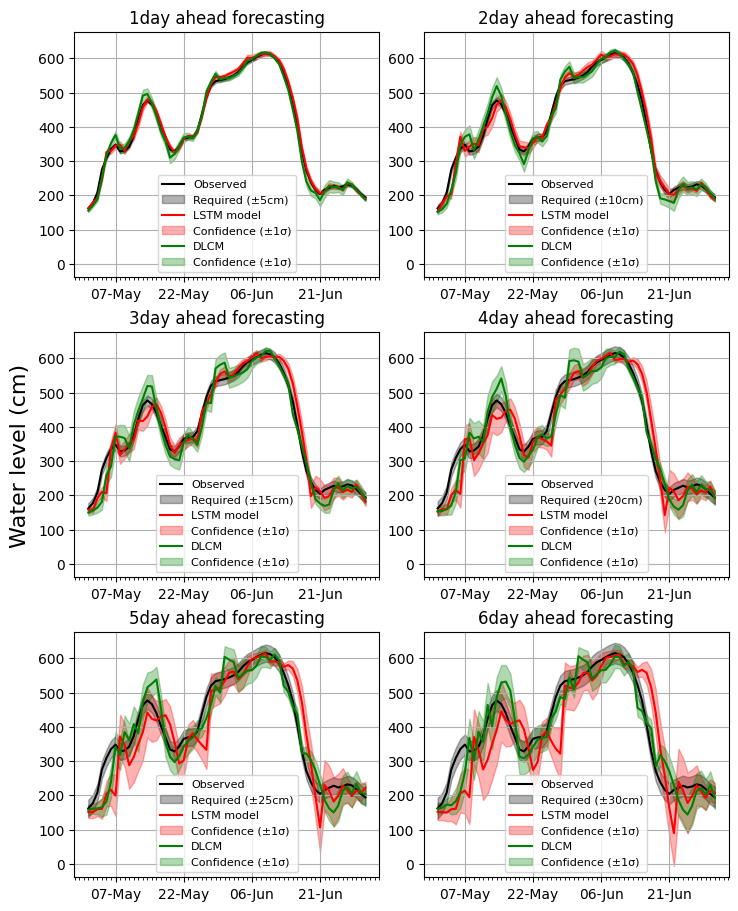

In [32]:
# set font size
plt.rcParams.update({'font.size': 10})

# plot lists for more compact script
colors = ['black', "black", 'red', 'red', 'green', 'green']
forecast_err = [5, 10, 15, 20, 25, 30]
conf = 'Confidence' + " (\u00B1" + str(sigma) + "\u03C3)"
labels = ['Observed', 'Required', 'LSTM model', conf, 'DLCM', conf]
days_to_plot = ['1day', '2day', '3day', '4day', '5day', '6day']
title_ext = " flood prediction"
y_title = 'Water level (cm)'
sub_title_ext = ' ahead forecasting'

# create plot
fig, axs = plt.subplots(3, 2, sharey='all')
fig.set_size_inches(7.27, 9)

collection_dlcm = []
collection_lstm = []
collection_obs = []
# loop for metrics
for jdx, day in enumerate(days_to_plot):
    label_idx = 0
    # plot observed
    axs[int(jdx / 2), jdx % 2].plot(x, y_obs, color=colors[0], label=labels[label_idx])
    label_idx += 1
    axs[int(jdx / 2), jdx % 2].fill_between(x, y_obs - forecast_err[jdx], y_obs + forecast_err[jdx], 
                                            color=colors[0],
                                            alpha=0.3, label=labels[label_idx])
    collection_obs.append(y_obs)
    label_idx += 1

    # shift prediction data by day
    predicted_shift = predicted.copy()
    predicted_shift.index = pd.DatetimeIndex(predicted_shift.index) + pd.DateOffset(int(day[0]))
    y_pred = predicted_shift[day][start_date:end_date].values
    # create plot
    axs[int(jdx / 2), jdx % 2].plot(
        x, y_pred, 
        color=colors[label_idx], label=labels[label_idx])
    label_idx += 1
    # confidence around predicted
    confidence_shift = confidence.copy()
    confidence_shift.index = pd.DatetimeIndex(confidence_shift.index) + pd.DateOffset(int(day[0]) - 1)
    conf = confidence_shift[day][start_date:end_date].values
    axs[int(jdx / 2), jdx % 2].fill_between(
        x, y_pred - conf, y_pred + conf, 
        color=colors[label_idx], alpha=0.3, 
        label=labels[label_idx])
    collection_lstm.append(y_pred)
    label_idx += 1

    # shift dlcm data by day
    dlcm_shift = dlcm.copy()
    dlcm_shift.index = pd.DatetimeIndex(dlcm_shift.index) + pd.DateOffset(int(day[0]))
    y_dlcm = dlcm_shift[day][start_date:end_date].values
    # create plot
    axs[int(jdx / 2), jdx % 2].plot(
        x, y_dlcm, 
        color=colors[label_idx], label=labels[label_idx])
    label_idx += 1
    # confidence around predicted
    confidence_dlcm_shift = confidence_dlcm.copy()
    confidence_dlcm_shift.index = pd.DatetimeIndex(confidence_dlcm_shift.index) + pd.DateOffset(int(day[0]) - 1)
    conf_dlcm = confidence_dlcm_shift[day][start_date:end_date].values
    # create plot
    axs[int(jdx / 2), jdx % 2].fill_between(
        x, y_dlcm - conf_dlcm, y_dlcm + conf_dlcm, 
        color=colors[label_idx], alpha=0.3, 
        label=labels[label_idx])
    collection_dlcm.append(y_dlcm)

    # set axis title
    axs[int(jdx / 2), jdx % 2].set_title(day + sub_title_ext, size=12)
    # format x_tics
    axs[int(jdx / 2), jdx % 2].xaxis.set_major_locator(mdates.DayLocator(interval=15))
    axs[int(jdx / 2), jdx % 2].xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
    axs[int(jdx / 2), jdx % 2].xaxis.set_minor_locator(mdates.DayLocator())
    # show ytick
    axs[int(jdx / 2), jdx % 2].yaxis.set_tick_params(labelbottom=True)
    # set grid
    axs[int(jdx / 2), jdx % 2].grid()
    # set legends
    tmp = labels[1]
    labels[1] = labels[1] + " (\u00B1" + str(forecast_err[jdx]) + "cm)"
    axs[int(jdx / 2), jdx % 2].legend(labels, loc='best', prop={'size': 8})
    labels[1] = tmp

# set other plot info and parameters
title = str(select) + title_ext
# fig.suptitle(title)
plt.rcParams['figure.constrained_layout.use'] = True
# plt.tight_layout()
fig.supylabel(y_title, size=16)
if to_export_plot:
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".svg"))
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".pdf"))
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".jpeg"), dpi=350)
plt.show()

# Graphical abstract

In [33]:
observed = pd.read_csv(os.path.join(PROJECT_PATH, "data", "y_true_mod.csv"), index_col=0)
predicted_LSTM = pd.read_csv(os.path.join(PROJECT_PATH, "data", "LSTM_pred_mod.csv"), index_col=0)
predicted_ATIVIZIG = pd.read_csv(os.path.join(PROJECT_PATH, "data", "Szeged_2014_2020_formated.csv"), index_col=0)

predicted = {'LSTM': predicted_LSTM, 'DLCM': predicted_ATIVIZIG}

In [34]:
# time interval
select = 2019
start_date = '2019-05-01'
end_date = '2019-07-01'

# get model confidence window_size and sigma can be changed
window_size = 10
sigma = 1

# shift observed data
observed_cp = observed.copy()
observed_cp.index = pd.DatetimeIndex(observed_cp.index) + pd.DateOffset(1)
x = observed_cp[start_date:end_date].index
y_obs = observed_cp['1day'][start_date:end_date].values

/home/zsvizi/workspace/water-prediction-lstm-tisza/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zsvizi/workspace/water-prediction-lstm-tisza/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zsvizi/workspace/water-prediction-lstm-tisza/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zsvizi/workspace/water-prediction-lstm-tisza/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


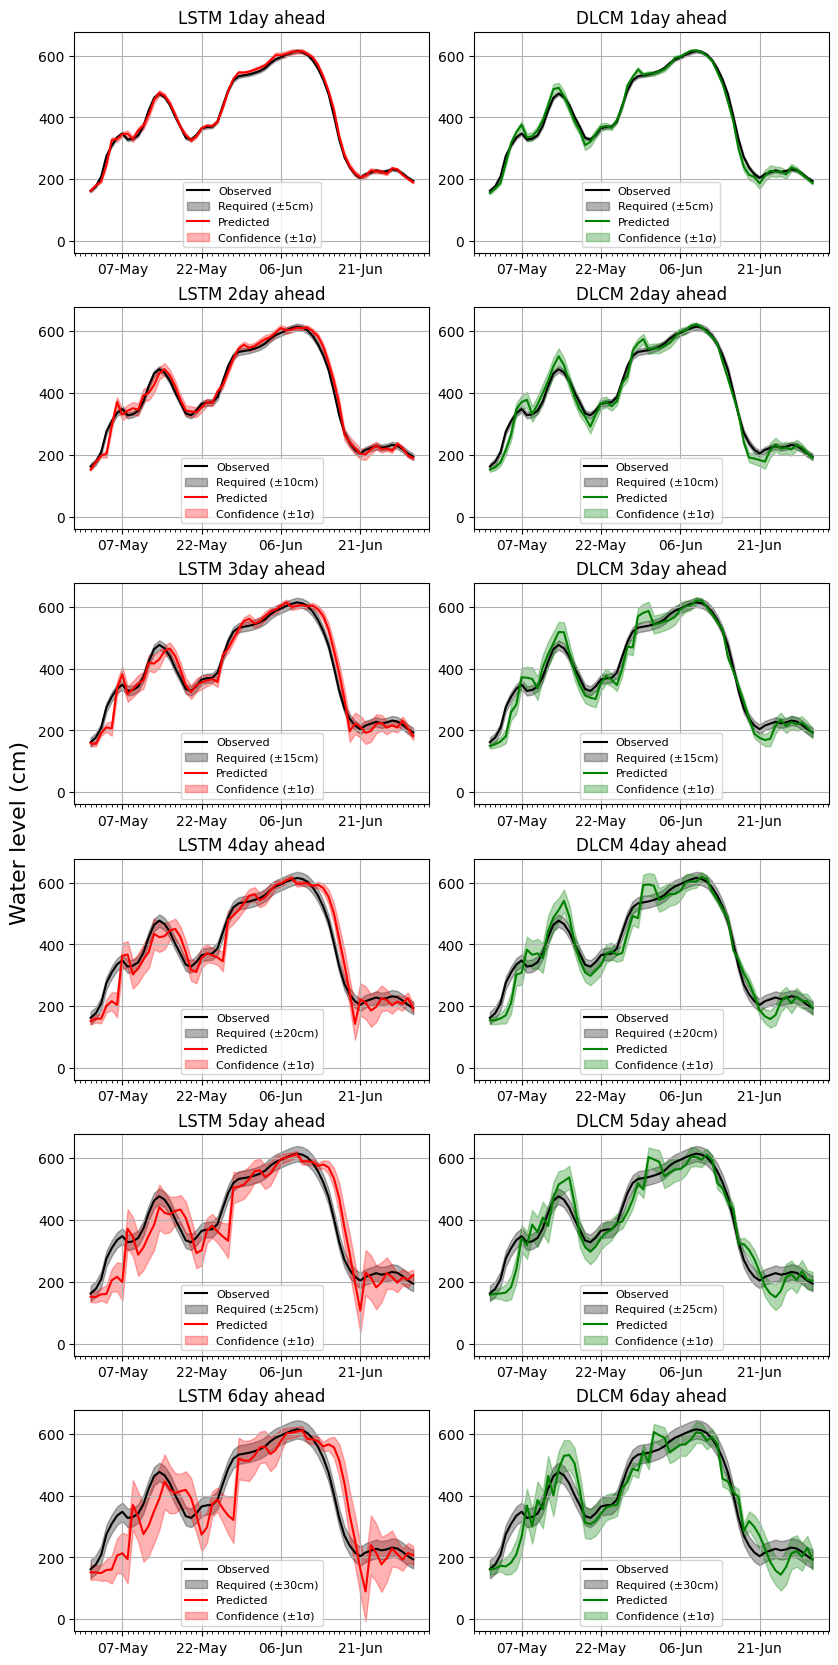

In [35]:
# set font size
plt.rcParams.update({'font.size': 10})

# plot lists for more compact script
colors = {"LSTM": ['black', 'red', 'black', 'red'], "DLCM": ['black', 'green', 'black', 'green']}
labels = ['Observed', 'Required', 'Predicted', 'Confidence']
days_to_plot = ['1day', '2day', '3day', '4day', '5day', '6day']
forecast_err = [5, 10, 15, 20, 25, 30, 35]
labels[3] = labels[3] + " (\u00B1" + str(sigma) + "\u03C3)"

# create plot
fig, axs = plt.subplots(len(days_to_plot), len(predicted.keys()), sharey='all')
fig.set_size_inches(8.27, 2 * 8.27)

# iterate models
day = ""
for idx, key in enumerate(predicted.keys()):
    # set confidence
    confidence = get_confidence(obs=observed, predi=predicted[key], w_size=window_size, sigm=sigma)
    # loop for metrics
    for jdx, day in enumerate(days_to_plot):
        # plot observed
        axs[jdx, idx].plot(x, y_obs, color=colors[key][0], label=labels[0])
        # plot forecast_target_errors around observed
        axs[jdx, idx].fill_between(
            x, y_obs - forecast_err[jdx], y_obs + forecast_err[jdx], 
            color=colors[key][2], alpha=0.3, label=labels[2])
        
        # shift prediction data by day
        predicted_shift = predicted[key].copy()
        predicted_shift.index = pd.DatetimeIndex(predicted_shift.index) + pd.DateOffset(int(day[0]))
        y_pred = predicted_shift[day][start_date:end_date].values
        # create plot
        axs[jdx, idx].plot(x, y_pred, color=colors[key][1], label=labels[1])
        # confidence around predicted
        confidence_shift = confidence.copy()
        confidence_shift.index = pd.DatetimeIndex(confidence_shift.index) + pd.DateOffset(int(day[0]) - 1)
        conf = confidence_shift[day][start_date:end_date].values
        # create plot
        axs[jdx, idx].fill_between(
            x, y_pred - conf, y_pred + conf, 
            color=colors[key][3], alpha=0.3, label=labels[3])

        # set axis title
        axs[jdx, idx].set_title(key + ' ' + day + ' ahead', size=12)
        # format x_tics
        axs[jdx, idx].xaxis.set_major_locator(mdates.DayLocator(interval=15))
        axs[jdx, idx].xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
        axs[jdx, idx].xaxis.set_minor_locator(mdates.DayLocator())
        # show ytick
        axs[jdx, idx].yaxis.set_tick_params(labelbottom=True)
        # set grid
        axs[jdx, idx].grid()
        # set legends
        tmp = labels[1]
        labels[1] = labels[1] + " (\u00B1" + str(forecast_err[jdx]) + "cm)"
        axs[jdx, idx].legend(labels, loc='best', prop={'size': 8})
        labels[1] = tmp

# set other plot info and parameters
title = 'LSTM and DLCM ' + str(select) + " flood prediction " + day + " ahead"
# fig.suptitle(title)
plt.rcParams['figure.constrained_layout.use'] = True
# plt.tight_layout()
fig.supylabel('Water level (cm)', size=16)

if to_export_plot:
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".pdf"))
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".jpeg"), dpi=350)
    plt.savefig(os.path.join(PROJECT_PATH, "plots", title + ".svg"))
    
plt.show()